<a href="https://colab.research.google.com/github/mariarodrius/AI-with-Copilot/blob/main/SalaryPredictionwithDeploymentStreamlit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'stack-overflow-2023-developers-survey:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3506731%2F6118265%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240617%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240617T175833Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D35cc1d7f0957c32b130b30bc1bdee9c23f0795f9b6239b7dd9d8762c8961c32c89099d087c17ee94d8f3e7acbbcb484e8b7b8bedbffc5e8e9d218c3a1b4b2ea9920ce95771b10d253e7648352752489ba4de189c6592f2856f4b80fac72e76f748556a418d94ba32c6e0c55d6b73ca85cdc40223e0388b044d8b183685d0229ca9ffc81f3c0dcce099d30ea480a39e81dffc3abcac56886f139b28c10211019c45933c76f1a4c816884fc54e0996d3d6f6df137a5d488603197e3a0c050cfaa241c906a3c895c79ab51562755d19c1297bbeb6da82a9d4fad2b281a0beffd5645330e76f7b0d8571a3d20d64a7e04af65203a8131bc2afe3bfb845dc501301d1'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 21448761 bytes downloaded
Downloaded and uncompressed: stack-overflow-2023-developers-survey
Data source import complete.


# Salary Prediction System

#### **Aim**

The project aims to build a Machine Learning model to predict the Annual Salary of Software Developers based on features like Country, Age, Education level, Years of Experience etc.. and build a web application for the same using Streamlit.

#### **About the dataset**

The data set used is the complete, cleaned results of the 2023 Stack Overflow Developer Survey conducted from May 8, 2023 to May 19, 2023.


#### **Import the Libraries**

In [2]:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/stack-overflow-2023-developers-survey/survey_results_schema.csv
/kaggle/input/stack-overflow-2023-developers-survey/so_survey_2023.pdf
/kaggle/input/stack-overflow-2023-developers-survey/README_2023.txt
/kaggle/input/stack-overflow-2023-developers-survey/survey_results_public.csv


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

#### **Load the Dataset**

In [4]:
df = pd.read_csv('/kaggle/input/stack-overflow-2023-developers-survey/survey_results_public.csv')
df.head()

,ResponseId,Q120,MainBranch,Age,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,...,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,ProfessionalTech,Industry,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,I agree,None of these,18-24 years old,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I agree,I am a developer by profession,25-34 years old,"Employed, full-time",Remote,Hobby;Contribute to open-source projects;Boots...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;Friend or fam...,Formal documentation provided by the owner of ...,...,1-2 times a week,10+ times a week,Never,15-30 minutes a day,15-30 minutes a day,DevOps function;Microservices;Automated testin...,"Information Services, IT, Software Development...",Appropriate in length,Easy,285000.0
2,3,I agree,I am a developer by profession,45-54 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby;Professional development or self-paced l...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Formal documentation provided by the owner of ...,...,6-10 times a week,6-10 times a week,3-5 times a week,30-60 minutes a day,30-60 minutes a day,DevOps function;Microservices;Automated testin...,"Information Services, IT, Software Development...",Appropriate in length,Easy,250000.0
3,4,I agree,I am a developer by profession,25-34 years old,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Colleague;Friend or family member;Other online...,Formal documentation provided by the owner of ...,...,1-2 times a week,10+ times a week,1-2 times a week,15-30 minutes a day,30-60 minutes a day,Automated testing;Continuous integration (CI) ...,NaN,Appropriate in length,Easy,156000.0
4,5,I agree,I am a developer by profession,25-34 years old,"Employed, full-time;Independent contractor, fr...",Remote,Hobby;Contribute to open-source projects;Profe...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Online Courses or Certi...,Formal documentation provided by the owner of ...,...,1-2 times a week,1-2 times a week,3-5 times a week,60-120 minutes a day,30-60 minutes a day,Microservices;Automated testing;Observability ...,Other,Appropriate in length,Neither easy nor difficult,23456.0


#### **Understanding the Data**

In [6]:
df.shape

(89184, 84)

The dataset has 89184 rows and 84 columns. We will choose most relevant columns for prediction and drop the rest.

In [7]:
df.columns

Index(['ResponseId', 'Q120', 'MainBranch', 'Age', 'Employment', 'RemoteWork',
       'CodingActivities', 'EdLevel', 'LearnCode', 'LearnCodeOnline',
       'LearnCodeCoursesCert', 'YearsCode', 'YearsCodePro', 'DevType',
       'OrgSize', 'PurchaseInfluence', 'TechList', 'BuyNewTool', 'Country',
       'Currency', 'CompTotal', 'LanguageHaveWorkedWith',
       'LanguageWantToWorkWith', 'DatabaseHaveWorkedWith',
       'DatabaseWantToWorkWith', 'PlatformHaveWorkedWith',
       'PlatformWantToWorkWith', 'WebframeHaveWorkedWith',
       'WebframeWantToWorkWith', 'MiscTechHaveWorkedWith',
       'MiscTechWantToWorkWith', 'ToolsTechHaveWorkedWith',
       'ToolsTechWantToWorkWith', 'NEWCollabToolsHaveWorkedWith',
       'NEWCollabToolsWantToWorkWith', 'OpSysPersonal use',
       'OpSysProfessional use', 'OfficeStackAsyncHaveWorkedWith',
       'OfficeStackAsyncWantToWorkWith', 'OfficeStackSyncHaveWorkedWith',
       'OfficeStackSyncWantToWorkWith', 'AISearchHaveWorkedWith',
       'AISearchWan

Rename the ConvertedCompYearly to Salary.

#### **Feature Engineering**

In [8]:
df=df.rename({'ConvertedCompYearly':"Salary"},axis=1)

In [9]:
df = df[df["Salary"].notnull()]

In [10]:
df.isna().sum().sort_values(ascending=False)

AINextVery similar                     46571
AINextNeither different nor similar    44685
AINextSomewhat similar                 44639
AINextVery different                   41681
AIDevWantToWorkWith                    37357
                                       ...  
Country                                    0
EdLevel                                    0
Age                                        0
MainBranch                                 0
Salary                                     0
Length: 84, dtype: int64

I am choosing Country, Age, RemoteWork, Employment, EdLevel, YearsCodePro, Salary columns.

In [11]:
df = df[["Country",'Age','RemoteWork','Employment','EdLevel','YearsCodePro','Salary']]
df.head()

,Country,Age,RemoteWork,Employment,EdLevel,YearsCodePro,Salary
1,United States of America,25-34 years old,Remote,"Employed, full-time","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",9,285000.0
2,United States of America,45-54 years old,"Hybrid (some remote, some in-person)","Employed, full-time","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",23,250000.0
3,United States of America,25-34 years old,"Hybrid (some remote, some in-person)","Employed, full-time","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",7,156000.0
4,Philippines,25-34 years old,Remote,"Employed, full-time;Independent contractor, fr...","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4,23456.0
5,United Kingdom of Great Britain and Northern I...,35-44 years old,Remote,"Employed, full-time",Some college/university study without earning ...,21,96828.0


Check the missing values.

In [12]:
df.isna().sum()

Country           0
Age               0
RemoteWork       79
Employment       12
EdLevel           0
YearsCodePro    194
Salary            0
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48019 entries, 1 to 89171
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country       48019 non-null  object 
 1   Age           48019 non-null  object 
 2   RemoteWork    47940 non-null  object 
 3   Employment    48007 non-null  object 
 4   EdLevel       48019 non-null  object 
 5   YearsCodePro  47825 non-null  object 
 6   Salary        48019 non-null  float64
dtypes: float64(1), object(6)
memory usage: 2.9+ MB


Since we have enough data, I prefer to drop the rows with null values for simplicity.

In [14]:
df=df.dropna()
df.isna().sum()

Country         0
Age             0
RemoteWork      0
Employment      0
EdLevel         0
YearsCodePro    0
Salary          0
dtype: int64

In [15]:
df.shape

(47747, 7)

In [16]:
df["Employment"].value_counts()

Employment
Employed, full-time                                                                             39155
Independent contractor, freelancer, or self-employed                                             3880
Employed, full-time;Independent contractor, freelancer, or self-employed                         3282
Employed, part-time                                                                               899
Independent contractor, freelancer, or self-employed;Employed, part-time                          238
Employed, full-time;Employed, part-time                                                           152
Employed, full-time;Independent contractor, freelancer, or self-employed;Employed, part-time      109
Independent contractor, freelancer, or self-employed;Retired                                       16
Employed, full-time;Retired                                                                         7
Employed, full-time;Independent contractor, freelancer, or self-employe

Let us create the dataframe with only full-time employed as we are predicting salary of full time employees only.

In [17]:
df = df[df["Employment"]=="Employed, full-time"]
df = df.drop("Employment",axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39155 entries, 1 to 89171
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country       39155 non-null  object 
 1   Age           39155 non-null  object 
 2   RemoteWork    39155 non-null  object 
 3   EdLevel       39155 non-null  object 
 4   YearsCodePro  39155 non-null  object 
 5   Salary        39155 non-null  float64
dtypes: float64(1), object(5)
memory usage: 2.1+ MB


In [18]:
df['Country'].value_counts()


Country
United States of America                                10569
Germany                                                  3201
United Kingdom of Great Britain and Northern Ireland     3072
Canada                                                   1807
India                                                    1600
                                                        ...  
Botswana                                                    1
Sierra Leone                                                1
Guyana                                                      1
Guinea-Bissau                                               1
Antigua and Barbuda                                         1
Name: count, Length: 165, dtype: int64

Let us put those countries with less than 400 entries into Other category.

In [19]:
def shorten_categories(categories,cutoff):
    categories_map = {}
    for i in range(len(categories)):
        if categories.values[i]>=cutoff:
            categories_map[categories.index[i]] = categories.index[i]
        else:
            categories_map[categories.index[i]] = 'Other'
    return categories_map

In [20]:
country_map = shorten_categories(df['Country'].value_counts(),400)
df["Country"] = df["Country"].map(country_map)

In [21]:
df['Country'].value_counts()

Country
United States of America                                10569
Other                                                    9282
Germany                                                  3201
United Kingdom of Great Britain and Northern Ireland     3072
Canada                                                   1807
India                                                    1600
France                                                   1458
Netherlands                                              1002
Australia                                                 985
Brazil                                                    972
Spain                                                     966
Sweden                                                    882
Italy                                                     826
Poland                                                    740
Switzerland                                               511
Denmark                                                   440


Let us check for Outliers.

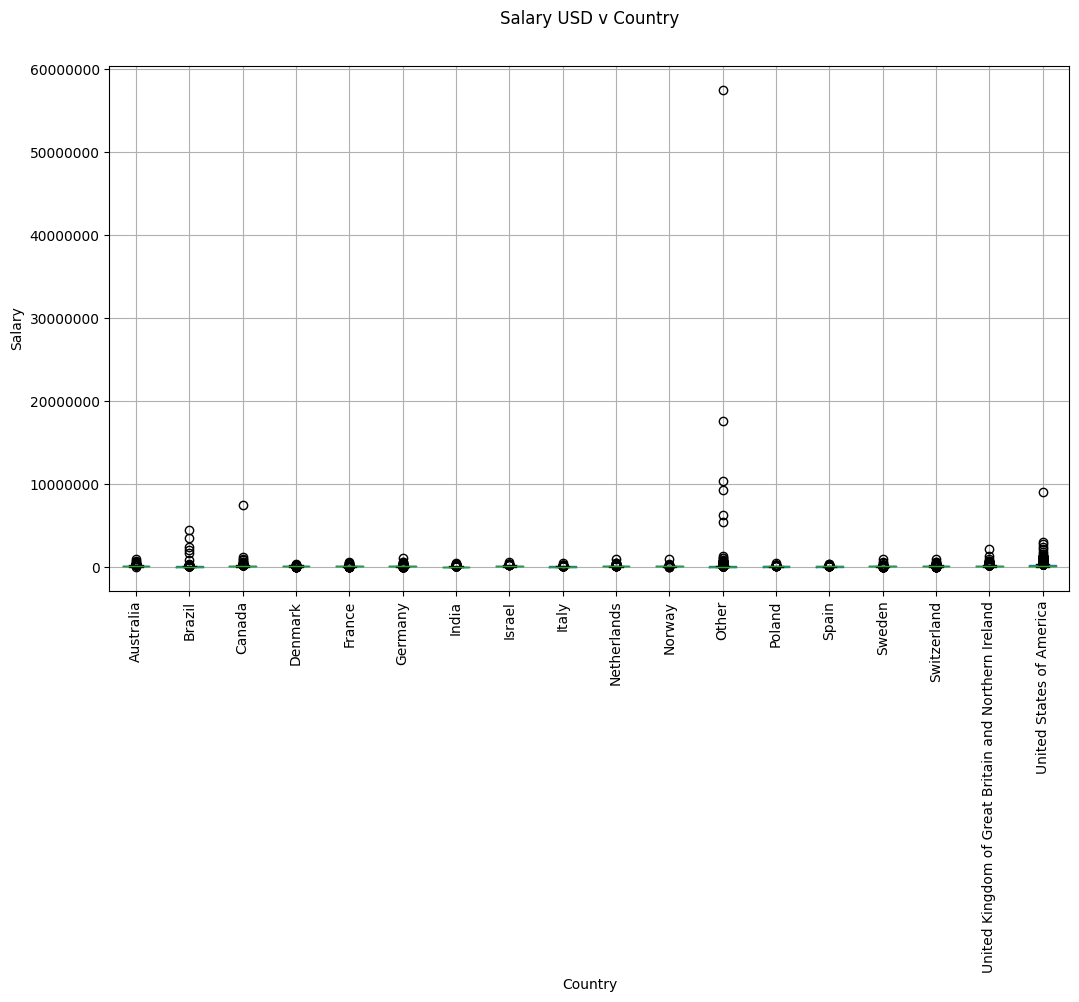

In [22]:
fig,ax = plt.subplots(1,1,figsize=(12,7))
plt.ticklabel_format(style = 'plain')

df.boxplot("Salary","Country",ax=ax)
plt.suptitle("Salary USD v Country")
plt.title('')
plt.ylabel("Salary")
plt.xticks(rotation=90)

plt.show()

Using capping method let us remove the outliers.

In [23]:
data = df.groupby('Country')['Salary'].describe().reset_index()[['Country','25%','75%']]
data.head()

,Country,25%,75%
0,Australia,72714.0,118987.0
1,Brazil,17042.0,48690.0
2,Canada,66916.0,118962.0
3,Denmark,74193.0,115028.0
4,France,43907.0,71750.0


In [24]:
df = df.merge(data, on = "Country",how ="left")
df.head()

,Country,Age,RemoteWork,EdLevel,YearsCodePro,Salary,25%,75%
0,United States of America,25-34 years old,Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",9,285000.0,110000.0,200000.0
1,United States of America,45-54 years old,"Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",23,250000.0,110000.0,200000.0
2,United States of America,25-34 years old,"Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",7,156000.0,110000.0,200000.0
3,United Kingdom of Great Britain and Northern I...,35-44 years old,Remote,Some college/university study without earning ...,21,96828.0,59586.0,111724.0
4,United States of America,35-44 years old,Remote,Some college/university study without earning ...,3,135000.0,110000.0,200000.0


In [25]:
mask = df["Salary"]<df['25%']
df.loc[mask,"Salary"] = df["25%"]

mask = df["Salary"]>df['75%']
df.loc[mask,"Salary"] = df["75%"]

df

,Country,Age,RemoteWork,EdLevel,YearsCodePro,Salary,25%,75%
0,United States of America,25-34 years old,Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",9,200000.0,110000.00,200000.0
1,United States of America,45-54 years old,"Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",23,200000.0,110000.00,200000.0
2,United States of America,25-34 years old,"Hybrid (some remote, some in-person)","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",7,156000.0,110000.00,200000.0
3,United Kingdom of Great Britain and Northern I...,35-44 years old,Remote,Some college/university study without earning ...,21,96828.0,59586.00,111724.0
4,United States of America,35-44 years old,Remote,Some college/university study without earning ...,3,135000.0,110000.00,200000.0
...,...,...,...,...,...,...,...,...
39150,Other,25-34 years old,"Hybrid (some remote, some in-person)","Professional degree (JD, MD, Ph.D, Ed.D, etc.)",5,28625.0,18197.25,68611.0
39151,Brazil,35-44 years old,Remote,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",24,48690.0,17042.00,48690.0
39152,India,18-24 years old,Remote,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",2,15752.0,8724.00,35139.0
39153,France,25-34 years old,"Hybrid (some remote, some in-person)","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",9,64254.0,43907.00,71750.0


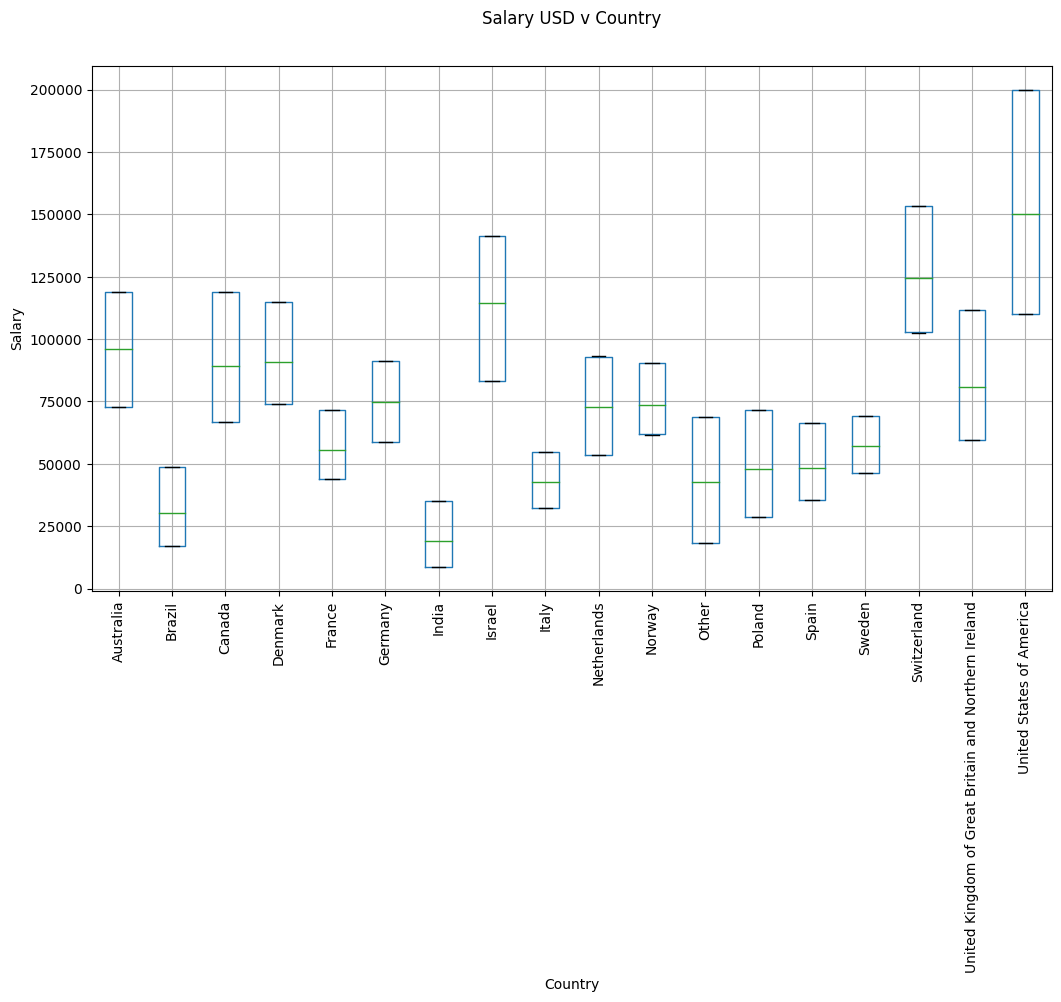

In [26]:
fig,ax = plt.subplots(1,1,figsize=(12,7))
plt.ticklabel_format(style = 'plain')

df.boxplot("Salary","Country",ax=ax)
plt.suptitle("Salary USD v Country")
plt.title('')
plt.ylabel("Salary")
plt.xticks(rotation=90)

plt.show()

In [27]:
df.drop(['25%','75%'],axis=1,inplace=True)

Let us create Age Bands.

In [28]:
df["Age"].unique()

array(['25-34 years old', '45-54 years old', '35-44 years old',
       'Under 18 years old', '55-64 years old', '18-24 years old',
       '65 years or older', 'Prefer not to say'], dtype=object)

In [29]:
def cleaned_age(x):
    if x == "45-54 years old":
        return 45
    if x == '25-34 years old':
        return 25
    if x == '35-44 years old':
        return 35
    if x == '55-64 years old':
        return 55
    if x == '18-24 years old':
        return 18
    if x == '65 years or older':
        return 65
    if x == 'Prefer not to say':
        return 0
    if x == 'Under 18 years old':
        return 17

df["Age"] = df["Age"].apply(cleaned_age)

df["Age"].value_counts()

Age
25    18633
35    11096
18     4128
45     3726
55     1340
65      186
17       27
0        19
Name: count, dtype: int64

In [30]:
df = df[df["Age"]!= 0]

df["Age"].value_counts()

Age
25    18633
35    11096
18     4128
45     3726
55     1340
65      186
17       27
Name: count, dtype: int64

Do similar feature engineering on YearsCodePro column and Edlevel as well.

In [31]:
df["YearsCodePro"].unique()

array(['9', '23', '7', '21', '3', '15', 'Less than 1 year', '10', '2',
       '6', '14', '5', '19', '13', '4', '16', '28', '11', '8', '24', '17',
       '29', '25', '12', '20', '18', '30', '27', '43', '1', '38', '33',
       '22', '40', '34', '42', '26', '31', '36', '39', '32', '44', '37',
       '35', '48', 'More than 50 years', '45', '41', '50', '46', '49',
       '47'], dtype=object)

In [32]:
def cleaned_exp(x):
    if x == "More than 50 years":
        return 50
    if x == 'Less than 1 year':
        return 0.5
    return float(x)

df["YearsCodePro"] = df["YearsCodePro"].apply(cleaned_exp)

df["YearsCodePro"].unique()

array([ 9. , 23. ,  7. , 21. ,  3. , 15. ,  0.5, 10. ,  2. ,  6. , 14. ,
        5. , 19. , 13. ,  4. , 16. , 28. , 11. ,  8. , 24. , 17. , 29. ,
       25. , 12. , 20. , 18. , 30. , 27. , 43. ,  1. , 38. , 33. , 22. ,
       40. , 34. , 42. , 26. , 31. , 36. , 39. , 32. , 44. , 37. , 35. ,
       48. , 50. , 45. , 41. , 46. , 49. , 47. ])

In [33]:
df["EdLevel"].unique()

array(['Bachelor’s degree (B.A., B.S., B.Eng., etc.)',
       'Some college/university study without earning a degree',
       'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)',
       'Primary/elementary school',
       'Professional degree (JD, MD, Ph.D, Ed.D, etc.)',
       'Associate degree (A.A., A.S., etc.)',
       'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)',
       'Something else'], dtype=object)

In [34]:
def cleaned_edu(x):
    if 'Bachelor’s degree' in x:
        return 'Bachelor’s degree'
    if 'Master’s degree' in x:
        return 'Master’s degree'
    if 'Professional degree' in x:
        return 'Professional degree'
    return 'Less than a Bachelors'

df["EdLevel"] = df["EdLevel"].apply(cleaned_edu)

df["EdLevel"].unique()

array(['Bachelor’s degree', 'Less than a Bachelors', 'Master’s degree',
       'Professional degree'], dtype=object)

LabelEncode the Categorical Columns.

In [ ]:
df["RemoteWork"].unique()

In [35]:
from sklearn.preprocessing import LabelEncoder
le_edu = LabelEncoder()
df["EdLevel"] = le_edu.fit_transform(df["EdLevel"])


le_coun = LabelEncoder()
df["Country"] = le_coun.fit_transform(df["Country"])

le_remote = LabelEncoder()
df["RemoteWork"] = le_remote.fit_transform(df["RemoteWork"])

df

,Country,Age,RemoteWork,EdLevel,YearsCodePro,Salary
0,17,25,2,0,9.0,200000.0
1,17,45,0,0,23.0,200000.0
2,17,25,0,0,7.0,156000.0
3,16,35,2,1,21.0,96828.0
4,17,35,2,1,3.0,135000.0
...,...,...,...,...,...,...
39150,11,25,0,3,5.0,28625.0
39151,1,35,2,2,24.0,48690.0
39152,6,18,2,0,2.0,15752.0
39153,4,25,0,2,9.0,64254.0


### **Model Development**

In [36]:
#splitting the feature and target columns
X = df.iloc[:,:-1]
y = df["Salary"]

In [37]:
#Scaling the data and splitting train and test data
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

mm = MinMaxScaler()
X = mm.fit_transform(X)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=1)

#### **Model1 - LinearRegression**

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
lm = LinearRegression()
lm.fit(X_train,y_train)

y_pred = lm.predict(X_test)

print("Mean Absolute Error:",mean_absolute_error(y_test,y_pred))
print("Root Mean Squared Error:",np.sqrt(mean_squared_error(y_test,y_pred)))
print("R2 Score:",r2_score(y_test,y_pred))



Mean Absolute Error: 34764.135980700004
Root Mean Squared Error: 42080.31589334795
R2 Score: 0.335679044978899


Mean Absolute Error: 34764.135980700004

Root Mean Squared Error: 42080.31589334795

R2 Score: 0.335679044978899

#### **Model2 - DecisionTreeRegressor**

In [39]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state=1)
dt.fit(X_train,y_train)

y_pred = dt.predict(X_test)

print("Mean Absolute Error:",mean_absolute_error(y_test,y_pred))
print("Root Mean Squared Error:",np.sqrt(mean_squared_error(y_test,y_pred)))
print("R2 Score:",r2_score(y_test,y_pred))


Mean Absolute Error: 17128.382402538115
Root Mean Squared Error: 23190.942482054088
R2 Score: 0.7982299197986444


Mean Absolute Error: 17128.382402538115

Root Mean Squared Error: 23190.942482054088

R2 Score: 0.7982299197986444

#### **Model3 - RandomForestRegressor**

In [40]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=1)
rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)

print("Mean Absolute Error:",mean_absolute_error(y_test,y_pred))
print("Root Mean Squared Error:",np.sqrt(mean_squared_error(y_test,y_pred)))
print("R2 Score:",r2_score(y_test,y_pred))


Mean Absolute Error: 16799.76533986574
Root Mean Squared Error: 22297.90246378704
R2 Score: 0.813470299915464


Mean Absolute Error: 16799.76533986574

Root Mean Squared Error: 22297.90246378704

R2 Score: 0.813470299915464

### **Hyper Parameter Tuning**

In [41]:
from sklearn.model_selection import GridSearchCV
max_depth = [None, 2,4,6,8,10,12]
parameters = {"max_depth": max_depth}

regressor = RandomForestRegressor(random_state=0)
gs = GridSearchCV(regressor, parameters, scoring='neg_mean_squared_error')
gs.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(random_state=0),
             param_grid={'max_depth': [None, 2, 4, 6, 8, 10, 12]},
             scoring='neg_mean_squared_error')

In [42]:
regressor = gs.best_estimator_

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
error = np.sqrt(mean_squared_error(y_test, y_pred))
print("R2 Score",r2_score(y_test,y_pred))
print("${:,.02f}".format(error))

R2 Score 0.8272327129967889
$21,459.56


R2 Score - 0.8272327129967889

Mean Squared Error - $21,459.56

In [43]:
from sklearn.model_selection import GridSearchCV

max_depth = [None, 2,4,6,8,10,12]
parameters = {"max_depth": max_depth}

regressor1 = DecisionTreeRegressor(random_state=0)
gs = GridSearchCV(regressor1, parameters, scoring='neg_mean_squared_error')
gs.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeRegressor(random_state=0),
             param_grid={'max_depth': [None, 2, 4, 6, 8, 10, 12]},
             scoring='neg_mean_squared_error')

In [44]:
regressor1 = gs.best_estimator_

regressor1.fit(X_train, y_train)
y_pred = regressor1.predict(X_test)
error = np.sqrt(mean_squared_error(y_test, y_pred))
print("R2 Score",r2_score(y_test,y_pred))
print("${:,.02f}".format(error))

R2 Score 0.8234397019954713
$21,693.85


R2 Score - 0.8234397019954713

Mean Squared Error - $21,693.85

### **Prediction using the model**

In [45]:
#Country, Age, RemoteWork,EdLevel,YearsCodePro
Z = np.array([['United States of America',25,'In-person','Bachelor’s degree',5]])
Z

array([['United States of America', '25', 'In-person',
        'Bachelor’s degree', '5']], dtype='<U24')

In [46]:

Z[:,0] = le_coun.transform(Z[:,0])
Z[:,2] = le_remote.transform(Z[:,2])
Z[:,3] = le_edu.transform(Z[:,3])
Z = Z.astype(float)
Z = mm.transform(Z)

Z

array([[1.        , 0.16666667, 0.5       , 0.        , 0.09090909]])

In [47]:
y_pred = regressor.predict(Z)
y_pred

array([131515.16314325])

### **Saving the Model**

In [48]:
import pickle

In [49]:
data = {"model": regressor, "le_country": le_coun, "le_education": le_edu,"le_remote":le_remote,"scaler":mm}
with open('salary_model.pkl', 'wb') as file:
    pickle.dump(data, file)

In [50]:
with open('salary_model.pkl', 'rb') as file:
    data = pickle.load(file)

regressor_loaded = data["model"]
le_coun = data["le_country"]
le_edu = data["le_education"]
le_remote = data["le_remote"]
mm = data["scaler"]

In [51]:
Y = np.array([['United States of America',25,'In-person','Bachelor’s degree',5]])
Y

array([['United States of America', '25', 'In-person',
        'Bachelor’s degree', '5']], dtype='<U24')

In [52]:
Y[:,0] = le_coun.transform(Y[:,0])
Y[:,2] = le_remote.transform(Y[:,2])
Y[:,3] = le_edu.transform(Y[:,3])
Y = Y.astype(float)
Y = mm.transform(Y)

In [53]:
y_pred = regressor_loaded.predict(Y)
y_pred

array([131515.16314325])

Now we can use this saved model for deployment.

In [ ]:
%%writefile app.py
import streamlit as st
from transformers import pipeline

@st.cache_resource
def load_model():
    return pipeline('text-generation', model='gpt2-xl', device='cuda')

model = load_model()

st.title("GPT-2 XL Text Generation")
prompt = st.text_input("Enter your prompt:", "Once upon a time")

if st.button("Generate"):
    with st.spinner('Generating...'):
        result = model(prompt, max_length=500, num_return_sequences=1)
        st.success(result[0]['generated_text'])

In [61]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.5 MB/s eta 0:00:00


In [64]:
%%writefile app.py
import streamlit as st
from transformers import pipeline

@st.cache_resource

def load_model():
    lm = LinearRegression()
    lm.fit(X_train,y_train)

    y_pred = lm.predict(X_test)

    return print("Mean Absolute Error:",mean_absolute_error(y_test,y_pred))
    return print("Root Mean Squared Error:",np.sqrt(mean_squared_error(y_test,y_pred)))
    return print("R2 Score:",r2_score(y_test,y_pred))

    return pipeline()

model = load_model()

st.title("Salary Predictor")
prompt = st.text_input("Country",	"Age",	"RemoteWork",	"EdLevel",	"YearsCodePro",	"Salary")

if st.button("Predict"):
    with st.spinner('Predicting...'):
        result = model(prompt, max_length=500, num_return_sequences=1)
        st.success(result[0]['generated_text'])

Overwriting app.py


In [ ]:
!streamlit run app.py --server.port 8511 & npx localtunnel --port 8511




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8511
  Network URL: http://172.28.0.12:8511
  External URL: http://35.247.115.81:8511

npx: installed 22 in 5.296s
your url is: https://gentle-nights-drop.loca.lt
2024-06-17 18:48:12.666262: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 18:48:12.666321: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 18:48:12.668326: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-17 18:48:12.685635: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimi

In [56]:
!pip install fastapi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.4/341.4 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━